# Project 1 - "BO4BT"

## Experimental Series 1 - Poly(Glycerol X) Optimisation - "PGXOpt"

### Part C - Hyperparameter Optimisation Comparison in Poly(Glycerol Citrate Itaconate) - "HypOptComp_PGCI"

#### Part D1 - Poly(Glycerol Citrate Itaconate) Bayesian Iteration (Samples=1 per round, StrengthPredictors=2, BalancePredictors=1 Objectives=1) - Iterative Bayesian Optimisation - "PtD1-PGCI-BOpt-\[9,27,1\]-S2B1O1"

# Stykke-0: Sampling Procedure

In [1]:
import os
import glob

import numpy as np
import pandas as pd

from ax import RangeParameter
from ax import ParameterType
from ax.service.ax_client import AxClient
from ax.modelbridge.generation_strategy import GenerationStrategy, GenerationStep
from ax.modelbridge.registry import Models

ScriptPath_str = os.getcwd()
os.chdir("/Users/github/BO4BT_ax")
from ExperimentalMethods import ExperimentalMethods
from Miscellaneous import chemical
from StoichiometryConverter import StoichiometryConverter
os.chdir(ScriptPath_str)

# Set the desired number of samples
NoSD_sca = 1

# Path for the prior dataset
PriorPath_str = os.getcwd() + "/" + glob.glob("*Stykke4.csv")[0]
prior_df = pd.read_csv(PriorPath_str)

# Instantiate dimension object(s)
s1_obj = RangeParameter(name='s1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
s2_obj = RangeParameter(name='s2', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
b1_obj = RangeParameter(name='b1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
# Create a list of dimensional object(s)
dims_lis = [s1_obj,s2_obj,b1_obj]

# Retrieving the bayes opt experiment if it exists, else making a new
# experiment from the stykke 4 dataset.
try:
    ExperimentPath_str = os.getcwd() + "/" + glob.glob("*.json")[0]
    ax_client = AxClient()
    ax_client = ax_client.load_from_json_file(ExperimentPath_str)
    print("The current experiment has been loaded.")
except:
    # Create a list of the parameters name strings
    parameterNames_lis = [parameter_obj.name for parameter_obj in dims_lis]
    # Create a list of parameter dictionaries based on the name strings
    parameters=[
        {"name": component, "type": "range", "bounds": [0.0, 1.0]}
        for component in parameterNames_lis[:]
    ]
    # Get all the training data from Stykke 4
    X_train_df = prior_df.filter(parameterNames_lis) # Bodge this should just be the parameterNames_lis
    n_train_sca = X_train_df.shape[0]
    y_train_arr = np.array(prior_df["DeltaPolymerMass_pct"]) # This is changed to DeltaPolymerMass_pct in new ones
    # Create a custom generation strategy
    gs = GenerationStrategy(
        steps=[
            GenerationStep(
                model=Models.GPEI,
                num_trials=-1,  # No limitation on how many trials should be produced from this step
            ),
        ]
    )
    # Setup the new experiment
    ax_client = AxClient(generation_strategy=gs)
    ax_client.create_experiment(
        name="PGIS",
        parameters=parameters,
        minimize=True,
    )
    # Attach the prior data
    for i in range(n_train_sca):
        ax_client.attach_trial(X_train_df.iloc[i, :].to_dict())
        ax_client.complete_trial(trial_index=i, raw_data=y_train_arr[i])
    # Save the experiment as a .json
    ax_client.save_to_json_file(os.getcwd() + "/" + "experiment.json")
    print("A new experiment has been created.")

# Get the next query points in a dictionary form then a list form
NxtQPs_dict = ax_client.get_next_trials(max_trials=NoSD_sca)[0]
NxtQPidxs_lis = list(NxtQPs_dict.keys())
NxtQPs_mat = np.array([NxtQPs_dict[i] for i in NxtQPidxs_lis])
NxtQPs_df = pd.DataFrame(NxtQPs_dict).T.fillna(0)
NxtQPs_mat = NxtQPs_df.to_numpy()
# Regenerate arrays for each of the dimensions
bdimsStr_li = ["s1_arr","s2_arr","b1_arr"]
for count,bdims_str in enumerate(bdimsStr_li):
    globals()[bdims_str] = NxtQPs_mat[:,count]
bdims_lis = [s1_arr,s2_arr,b1_arr]

# Instantiate the chemical object(s)
chemG_obj = chemical(name="Glycerol",abbrev_name="G",lower=1,upper=1,mr=92.09)
chemCA_obj = chemical(name="Citric Acid",abbrev_name="CA",lower=0.5,upper=2,mr=192.12)
chemIA_obj = chemical(name="Itaconic Acid",abbrev_name="IA",lower=1,upper=2,mr=130.12)
chem_lis = [chemG_obj,chemCA_obj,chemIA_obj]

# Instantiate stoichiometry converter class
StoiConv_obj = StoichiometryConverter()
# Generate stoichiometries
Gsr_arr,CAsr_arr,IAsr_arr = StoiConv_obj.threedim.conv(chem_lis,bdims_lis)
sr_lis = [Gsr_arr,CAsr_arr,IAsr_arr]

# Instantiate the experimental methods class
ExptMthd_obj = ExperimentalMethods()
# Setup and build the mould filling sequence list
alpha_lis = ["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
numeric_lis = ["1","2","3","4","5","6"]
fill_lis = ExptMthd_obj.setup.moulds(alpha_lis,numeric_lis)
# Initialise the file structure for data storage
Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str = ExptMthd_obj.setup.initcsv(chem_lis,dims_lis)
CsvPaths_lis = [Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str]

# Cut down fill lis, so only available mould positions left
ModFill_lis = []
for _ in fill_lis:
    ModFill_lis.append(_)
for mould in prior_df["mould_position"]:
    ModFill_lis.remove(f"{mould}")
# Obtain the next moulds to align with next query points
CurrentFill_lis = []
for i in range(NoSD_sca):
    CurrentFill_lis.append(ModFill_lis[i])
fill_lis = CurrentFill_lis

df = ax_client.get_trials_data_frame()
df

[INFO 06-01 10:04:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-01 10:04:30] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.


The current experiment has been loaded.


[INFO 06-01 10:04:31] ax.service.ax_client: Generated new trial 14 with parameters {'s1': 0.398964, 's2': 0.210975, 'b1': 0.0}.


,trial_index,arm_name,trial_status,generation_method,objective,s1,s2,b1
0,0,0_0,COMPLETED,Manual,-13.441874,0.574273,0.838241,0.726713
1,1,1_0,COMPLETED,Manual,-14.012909,0.074273,0.338241,0.226713
2,2,2_0,COMPLETED,Manual,-13.142638,0.324273,0.088241,0.476713
3,3,3_0,COMPLETED,Manual,-11.367643,0.824273,0.588241,0.976713
4,4,4_0,COMPLETED,Manual,-12.840313,0.949273,0.213241,0.351713
5,5,5_0,COMPLETED,Manual,-13.076645,0.449273,0.713241,0.851713
6,6,6_0,COMPLETED,Manual,-10.908235,0.199273,0.963241,0.101713
7,7,7_0,COMPLETED,Manual,-13.765688,0.699273,0.463241,0.601713
8,8,8_0,COMPLETED,Manual,-12.944519,0.493322,0.366795,0.487736
9,9,9_0,COMPLETED,GPEI,-14.936751,0.000000,0.123324,0.225994


# Stykke-1: Sample Preparation

In [2]:
# Instantiate the experimental methods stykke1 subclass
styk1_obj = ExperimentalMethods.stykke1()
# Initiate stykke1 sample preparation
MPs_lis,MoSMs_lis,MoSMPP_lis,MoPP_lis,ToPP_lis = styk1_obj.run(NoSD_sca,fill_lis,sr_lis,chem_lis)
# Print the final findings of the preparation
styk1_obj.show(dims_lis,bdims_lis,sr_lis,chem_lis,MPs_lis,MoSMs_lis,MoSMPP_lis,MoPP_lis,ToPP_lis)


Please place command here. (n/b for next/break)
		Input:  n
	What is the mass of Glycerol in the beaker? (x.xx g)
		Input:  3.55
	What is the mass of the silicone mould? (x.xx g)
		Input:  3.26
						Sample C3
					1.0 G + 0.39 CA + 0.3 IA
					3.55g G + 2.92g CA + 1.48g IA

	What is the mass of mould C3 and its prepolymer contents? (x.xx g)
		Input:  6.6

Please place command here. (n/b for next/break)
		Input:  n

Sample Preparation Finished


Final Information-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Silicone Mould Positions List:
['C3']
s1 Bayes' Dimension List:
[0.0]
s2 Bayes' Dimension List:
[0.398963611121917]
b1 Bayes' Dimension List:
[0.2109747630197549]
G Stoichiometry List:
[1.0]
CA Stoichiometry List:
[0.39451261849012254]
IA Stoichiometry List:
[0.295146016329707]
Silicone Mould Masses List:
[3.26]
Silicone Mould & Prepolymer Masses List:
[6.6]
Prepolymer Masses List:
[3.34]
Time of Oven Insertion List:
['2023-06-01 10:09:46'

In [3]:
# Save the final findings of the preparation
styk1_obj.save(CsvPaths_lis,MPs_lis,ToPP_lis,chem_lis,dims_lis,bdims_lis,sr_lis,MoSMs_lis,MoSMPP_lis,MoPP_lis)
# Save the experiments state with the new trials incomplete
ax_client.save_to_json_file(os.getcwd() + "/" + "experiment.json")

[INFO 06-01 10:09:47] ax.service.ax_client: Saved JSON-serialized state of optimization to `/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/PhD/Project-1_BO4BT/ExperimentalSeries-1_PGXOpt/Part-C_HypOptComp_PGCI/Part-D1_PGCI-BOpt-9,27,1-S2B1O1/experiment.json`.


# Stykke-2: Updating Sample Monitoring Data

In [1]:
import os

from ax import RangeParameter
from ax import ParameterType

ScriptPath_str = os.getcwd()
os.chdir("/Users/github/BO4BT_ax")
from ExperimentalMethods import ExperimentalMethods
from Miscellaneous import chemical
os.chdir(ScriptPath_str)

# Instantiate dimension object(s)
s1_obj = RangeParameter(name='s1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
s2_obj = RangeParameter(name='s2', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
b1_obj = RangeParameter(name='b1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
dims_lis = [s1_obj,s2_obj,b1_obj]

# Set the chemicals of interest
chemG_obj = chemical(name="Glycerol",abbrev_name="G",lower=1,upper=1,mr=92.09)
chemCA_obj = chemical(name="Citric Acid",abbrev_name="CA",lower=0.5,upper=2,mr=192.12)
chemIA_obj = chemical(name="Itaconic Acid",abbrev_name="IA",lower=1,upper=2,mr=130.12)
chem_lis = [chemG_obj,chemCA_obj,chemIA_obj]

# Instantiate the experimental methods class
ExptMthd_obj = ExperimentalMethods()
# Initialise the file structure for data storage
Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str = ExptMthd_obj.setup.initcsv(chem_lis,dims_lis)
CsvPaths_lis = [Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str]

# Instantiate the experimental methods stykke2 subclass
styk2_obj = ExperimentalMethods.stykke2()
# Initiate the stykke2 sample mass checking and saving procedure
styk2_obj.runsave(CsvPaths_lis)

Mass available for silicone mould C3 and its prepolymer contents? (y/n)
		Input:  y
	What is the current mass of silicone mould C3 and its prepolymer contents? (x.xx g)
		Input:  6.09


# Stykke-3: Visualising Sample Monitoring Data

In [2]:
import os

from ax import RangeParameter
from ax import ParameterType

ScriptPath_str = os.getcwd()
os.chdir("/Users/github/BO4BT_ax")
from ExperimentalMethods import ExperimentalMethods
from Miscellaneous import chemical
os.chdir(ScriptPath_str)

# Instantiate dimension object(s)
s1_obj = RangeParameter(name='s1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
s2_obj = RangeParameter(name='s2', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
b1_obj = RangeParameter(name='b1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
dims_lis = [s1_obj,s2_obj,b1_obj]

# Instantiate the chemical object(s)
chemG_obj = chemical(name="Glycerol",abbrev_name="G",lower=1,upper=1,mr=92.09)
chemCA_obj = chemical(name="Citric Acid",abbrev_name="CA",lower=0.5,upper=2,mr=192.12)
chemIA_obj = chemical(name="Itaconic Acid",abbrev_name="IA",lower=1,upper=2,mr=130.12)
chem_lis = [chemG_obj,chemCA_obj,chemIA_obj]

# Instantiate the experimental methods class
ExptMthd_obj = ExperimentalMethods()
# Initialise the file structure for data storage
Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str = ExptMthd_obj.setup.initcsv(chem_lis,dims_lis)
CsvPaths_lis = [Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str]

# Instantiate the experimental methods stykke3 subclass
styk3_obj = ExperimentalMethods.stykke3()
# Initiate the stykke3 sample progress checking procedure
styk3_obj.runsave(CsvPaths_lis)

/Users/thomasdodd/opt/miniconda3/envs/ax_env/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


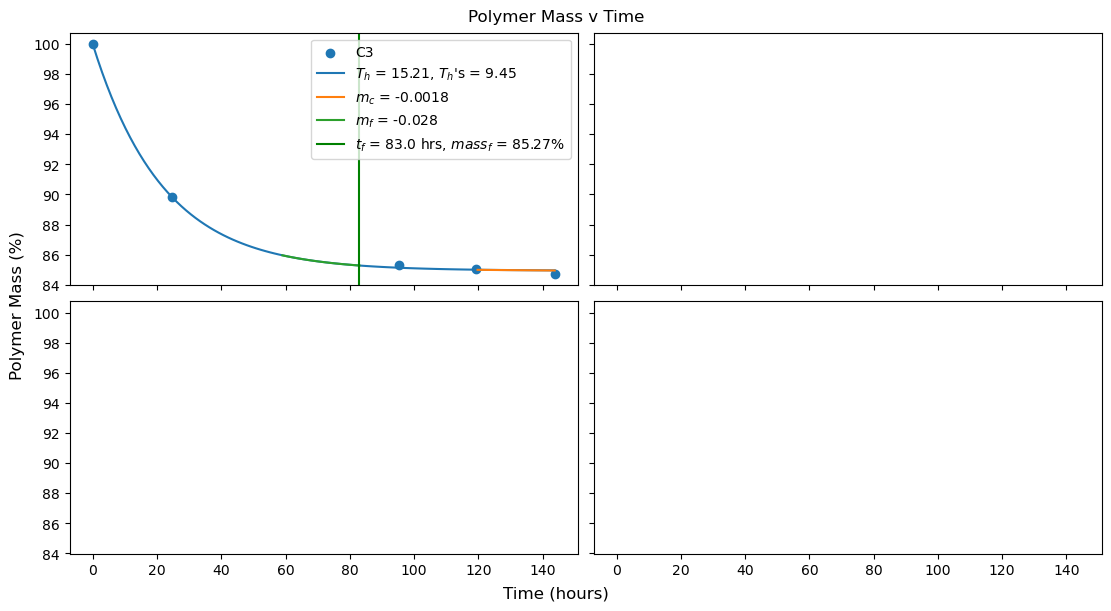

In [3]:
# Initiate the dashboard view of current samples and their progress
styk3_obj.plotdash(CsvPaths_lis,11,6)

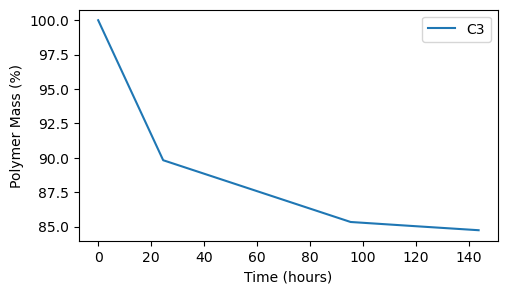

In [4]:
# Initiate the overview diagram of current samples and their progress
styk3_obj.plotoverview(CsvPaths_lis,5.4,3)

# Stykke-4: Stowing Final Dataset

In [5]:
import os
import glob

import numpy as np
import pandas as pd

from ax import RangeParameter
from ax import ParameterType
from ax.service.ax_client import AxClient

ScriptPath_str = os.getcwd()
os.chdir("/Users/github/BO4BT_ax")
from ExperimentalMethods import ExperimentalMethods
from Miscellaneous import chemical
os.chdir(ScriptPath_str)

# Instantiate dimension object(s)
s1_obj = RangeParameter(name='s1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
s2_obj = RangeParameter(name='s2', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
b1_obj = RangeParameter(name='b1', parameter_type=ParameterType.FLOAT, lower=0, upper=1)
dims_lis = [s1_obj,s2_obj,b1_obj]

# Instantiate the chemical object(s)
chemG_obj = chemical(name="Glycerol",abbrev_name="G",lower=1,upper=1,mr=92.09)
chemCA_obj = chemical(name="Citric Acid",abbrev_name="CA",lower=0.5,upper=2,mr=192.12)
chemIA_obj = chemical(name="Itaconic Acid",abbrev_name="IA",lower=1,upper=2,mr=130.12)
chem_lis = [chemG_obj,chemCA_obj,chemIA_obj]

# Instantiate the experimental methods class
ExptMthd_obj = ExperimentalMethods()
# Initialise the file structure for data storage
Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str = ExptMthd_obj.setup.initcsv(chem_lis,dims_lis)
CsvPaths_lis = [Csv1Path_str,Csv2Path_str,Csv3Path_str,Csv4Path_str]

StartObjectiveLen_sca = len(np.array((pd.read_csv(os.getcwd() + "/" + glob.glob("*_Stykke4.csv")[0]))["DeltaPolymerMass_pct"]))

# Instantiate the experimental methods stykke4 subclass
styk4_obj = ExperimentalMethods.stykke4()
# Initiate the stykke4 progress saving procedure
styk4_obj.runsave(chem_lis,CsvPaths_lis,dims_lis)

EndObjectiveLen_sca = len(np.array((pd.read_csv(os.getcwd() + "/" + glob.glob("*_Stykke4.csv")[0]))["DeltaPolymerMass_pct"]))
EndObjective_arr = np.array((pd.read_csv(os.getcwd() + "/" + glob.glob("*_Stykke4.csv")[0]))["DeltaPolymerMass_pct"])

NewObjectives_arr = EndObjective_arr[StartObjectiveLen_sca:EndObjectiveLen_sca]

print(NewObjectives_arr)

# Save the latest results as complete within the Ax experiment .json file
ExperimentPath_str = os.getcwd() + "/" + glob.glob("*.json")[0]
ax_client = AxClient()
ax_client = ax_client.load_from_json_file(ExperimentPath_str)
df = ax_client.get_trials_data_frame()
df = df.query("trial_status == 'RUNNING'")
TrialIdxs_lis = np.array(df.trial_index)
for TrialIdx_sca,objective_sca in zip(TrialIdxs_lis,NewObjectives_arr):
    ax_client.complete_trial(trial_index=int(TrialIdx_sca),raw_data=objective_sca)
ax_client.save_to_json_file(os.getcwd() + "/" + "experiment.json")
df = ax_client.get_trials_data_frame()
df

[INFO 06-07 09:59:27] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-07 09:59:27] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 06-07 09:59:27] ax.service.ax_client: Completed trial 14 with data: {'objective': (-14.727967, None)}.
[INFO 06-07 09:59:27] ax.service.ax_client: Saved JSON-serialized state of optimization to `/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/PhD/Project-1_BO4BT/ExperimentalSeries-1_PGXOpt/Part-C_HypOptComp_PGCI/Part-D1_PGCI-BOpt-9,27,1-S2B1O1/experiment.json`.


[-14.72796708]


,trial_index,arm_name,trial_status,generation_method,objective,s1,s2,b1
0,0,0_0,COMPLETED,Manual,-13.441874,0.574273,0.838241,0.726713
1,1,1_0,COMPLETED,Manual,-14.012909,0.074273,0.338241,0.226713
2,2,2_0,COMPLETED,Manual,-13.142638,0.324273,0.088241,0.476713
3,3,3_0,COMPLETED,Manual,-11.367643,0.824273,0.588241,0.976713
4,4,4_0,COMPLETED,Manual,-12.840313,0.949273,0.213241,0.351713
5,5,5_0,COMPLETED,Manual,-13.076645,0.449273,0.713241,0.851713
6,6,6_0,COMPLETED,Manual,-10.908235,0.199273,0.963241,0.101713
7,7,7_0,COMPLETED,Manual,-13.765688,0.699273,0.463241,0.601713
8,8,8_0,COMPLETED,Manual,-12.944519,0.493322,0.366795,0.487736
9,9,9_0,COMPLETED,GPEI,-14.936751,0.000000,0.123324,0.225994


In [13]:
# Bodge because of mess up in code, had to manually insert first bayesian run.
import os
import glob
from ax.service.ax_client import AxClient
ExperimentPath_str = os.getcwd() + "/" + glob.glob("*.json")[0]
ax_client = AxClient()
ax_client = ax_client.load_from_json_file(ExperimentPath_str)
ax_client.attach_trial({'s1': 0.4933223634423558, 's2': 0.3667950101884835, 'b1': 0.4877359838003733})
ax_client.complete_trial(trial_index=8,raw_data=-12.944519468671189)
ax_client.save_to_json_file(os.getcwd() + "/" + "experiment.json")
df = ax_client.get_trials_data_frame()
df

[INFO 04-25 09:52:25] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 04-25 09:52:25] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 04-25 09:52:25] ax.core.experiment: Attached custom parameterizations [{'s1': 0.493322, 's2': 0.366795, 'b1': 0.487736}] as trial 8.
[INFO 04-25 09:52:25] ax.service.ax_client: Completed trial 8 with data: {'objective': (-12.944519, None)}.
[INFO 04-25 09:52:25] ax.service.ax_client: Saved JSON-serialized state of optimization to `/Users/thomasdodd/Library/CloudStorage/OneDrive-MillfieldEnterprisesLimited/Cambridge/PhD/Project-1_BO4BT/ExperimentalSeries-1_PGXOpt/Part-C_HypOptComp_PGCI/Part-D1_PGCI-BOpt-[9,27,1]-S2B1O1/experiment.json`.


,trial_index,arm_name,trial_status,generation_method,objective,s1,s2,b1
0,0,0_0,COMPLETED,Manual,-13.441874,0.574273,0.838241,0.726713
1,1,1_0,COMPLETED,Manual,-14.012909,0.074273,0.338241,0.226713
2,2,2_0,COMPLETED,Manual,-13.142638,0.324273,0.088241,0.476713
3,3,3_0,COMPLETED,Manual,-11.367643,0.824273,0.588241,0.976713
4,4,4_0,COMPLETED,Manual,-12.840313,0.949273,0.213241,0.351713
5,5,5_0,COMPLETED,Manual,-13.076645,0.449273,0.713241,0.851713
6,6,6_0,COMPLETED,Manual,-10.908235,0.199273,0.963241,0.101713
7,7,7_0,COMPLETED,Manual,-13.765688,0.699273,0.463241,0.601713
8,8,8_0,COMPLETED,Manual,-12.944519,0.493322,0.366795,0.487736
